# Road Traffic Fine Management

### Table of Contents

* [Data Extraction Checklist](#DataExtractionChecklist)
* [Data Quality Check](#DataQualityCheck)
* [Data Transformation](#DataTransformation)
* [Process Discovery](#ProcessDiscovery)
    * [Variant Analysis](#VariantAnalysis)
    * [Process Flow Graph](#ProcessFlowGraph)
    * [Transition Matrix](#TransitionMatrix)
    * [Process Deviation](#ConformanceChecking)
* [Timing Analysis](#TimingAnalysis)
    * [Case Duration](#CaseDuration)
    * [Event Duration](#EventDuration)
    * [Conformance Checking](#ConformanceChecking2)


## Data Extraction Checklist<a class="anchor" id="DataExtractionChecklist"></a>


### 1. Which Process?

##### Road traffic fine management process
The process starts with the Create Fine that writes four variables: Amount, Points, Payment and Dismissal. Amount refers to the amount that needs to be paid by the offender, Points records the number of points that are deducted from the offender's license. Payment is the total amount that has been paid by the offender. The offender can pay the fine partly or fully at many moments in time. Dismissal contains a character that encodes the diverse reasons for a possible dismissal of the fine. A value of NIL encodes that the fine is not dismissed (i.e., has to be paid); any other value encodes different motivations.

After the creation of the fine, the fine notification is sent by the police to the offender's place of residence, or when such a notification is received by the offender. The fine must be sent within 90 days since it's creation else the fine expires. If a notification is sent, the offender needs to pay the postal expenses. If the offender does not pay within 180 days, a penalty is added, usually as much as the fine's amount. If the entire amount is paid (or, even, by misake, more than that amount), the fine is closed.

##### Appeal to a judge or prefecture
After being notified by post, the offender can appeal against the fine throuh a judge and/or the prefecture within 60 days. The prefect has 210 days to respond if you send the letter directly to his address. If the Prefect doesn't respond, the appeal is considered accepted and you will be free of debt. If you send the letter to the authority that issued you the ticket, it will have 180 days. If the appeal is successful, your case will be archived within 120 days, the variable dismissal is set to G (Judge) or # (Prefecture) and the case ends. If the appeal is rejected, the Prefect will notify the offender within 150 days (Receive Result) and the offender will have 30 days to make the payment (most times double the fine).

##### Send to credit collection agency
You have 60 days from the notification to pay your ticket. If you do not pay after 60 days, the fine will become an enforcement order. If the case is not closed 6 months after opening, the fine collection is sent to a debt collection agency.

### 2. Questions about Process?
The question we are to answer relates to conformance. 
* Is the process being done as expected above? For example, are there delays in sending fines, appealing to judge/prefecture. 
* How long does it take from when the fine is sent until it is sent to credit collection agency?
* Are fines sent to the credit collection even after payments are made?
* How long does it take from appeal to judge/prefecture to receive result?
* For those cases with a successful appeal, how much is lost for sending fines?

### 3. Which IT System?
The IT system where the log was extracted from was not specified.

### 4. Case ID?
The case ID to be used is the case column.

### 5. Activities
The event column contains 11 activities which were performed over these cases. The activities include:
1. Create fine
2. Send Fine
3. Insert Fine Notification
4. Add penalty
5. Payment               
6. Send for Credit Collection         
7. Insert Date Appeal to Prefecture
8. Send Appeal to Prefecture    
9. Receive Result Appeal from Prefecture
10. Notify Result Appeal to Offender
11. Appeal to Judge

### 6. Timestamps
There are two columns which represent the activity timestamps. startTime and completeTime. Both columns have the same timestamps. During Data transformation, only the one of the columns will be used.

### 7. Other attributes
The dataset contains other attributes which includes:
* <b><i>amount</b></i>: shows the amount the offender has to pay.
* <b><i>notificationType</b></i>: includes two variables; <b>P</b>, <b>C</b> and it is inputed when the <i>Insert fine notification</i> activity is done.
* <b><i>expense</b></i>: Which records the amount spent in sending the fine notification
* <b><i>lastSent</b></i>: This is similar to notificationType and contains 3 variables <b>P</b>, <b>N</b> and <b>C</b>. This is also filled when the <i>Insert fine notification</i> activity is done.
* <b><i>paymentAmount</b></i>: This contains the amount paid by the offender and is filled when a <b>Payment</b> is made.
* <b><i>article</b></i>: this column indicates the road article that was broken and led to the fine.
* <b><i>points</b></i>: this shows how many points was deducted from the offender's licence
* <b><i>org:resource</b></i>: this contains the person who gave the fine. It is constant through out the case.
* <b><i>dismissal</b></i>: shows the dismissal value. NIL means no dismissal, G means a successful appeal to the judge and # means a successful appeal to the prefecture.
* <b><i>vehicleClass</b></i>: indicates the vehicle the offender was driving
* <b><i>totalPaymentAmount</b></i>: records the total amount paid by the offender
* <b><i>matricola</b></i>: it's filled with zero. It is always inputted when an appeal is made to a judge.


### 8. Selection method
In analysing processes, it is important to consider only finished cased. As described above, a case can end in four different ways:
- When the fine is paid i.e., <b>Payment</b> activity;
- Sent for credit collection;
- Successful appeal to Prefecture (i.e., dismissal is set to <b>#</b>); and
- Successful appeal to Judge (i.e., dismissal is set to <b>G</b>)

To ensure that we use only complete cases, we will filter for cases that meets the above criteria. After filtering, we ended up with 128,268 number of cases.

### 9. Timeframe
The dataset contains cases from 1st January 2000 to 17th June 2013.

* Is there a situation where a case do not start with creating a fine? Done
* Are there situations where the fines is not sent within 150 days? Done
* No of cases where fine was notified and not paid 60 days later, but no penalty was added. Penalty is added automatically after 60 days
* Are there cases where the offender appealed to a judge/prefect after 60 days? Done
* For cases where the the offender has appealed to the prefect, did the prefect respond within 210 days?
* How long does it take to send the fine for collection? Longer than 180 days?
* No of cases above 180 days and no penalty was added
* Amount lost due to a successful appeal? Done
* Amount not sent to credit collection agency after 180 days
* Amount collected from credit collection agency
* Check the payments. Break it into three categories: Not paid, underpaid, overpaid.
* For the overpaid, are they returned?
* Are they sent to credit collection agencies after they have been paid?
* It does not tell us when the Dismissal column is changed to # or G
* For cases with successful appeal, do they still send the result to the credit collection agency/will the fine be paid?

In [1]:
import pandas as pd
import numpy as np
import graphviz

In [2]:
df = pd.read_csv('Road traffic fine manaement process.csv')
df

,case,event,startTime,completeTime,amount,notificationType,expense,lastSent,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola
0,A1,Create Fine,2006/07/23 23:00:00.000,2006/07/23 23:00:00.000,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.0,NaN
1,A1,Send Fine,2006/12/05 00:00:00.000,2006/12/05 00:00:00.000,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.0,NaN
2,A100,Create Fine,2006/08/01 23:00:00.000,2006/08/01 23:00:00.000,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.0,NaN
3,A100,Send Fine,2006/12/12 00:00:00.000,2006/12/12 00:00:00.000,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.0,NaN
4,A100,Insert Fine Notification,2007/01/15 00:00:00.000,2007/01/15 00:00:00.000,35.0,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,V9999,Create Fine,2002/09/06 23:00:00.000,2002/09/06 23:00:00.000,131.0,NaN,NaN,NaN,NaN,142,0,25,NIL,A,0.0,NaN
561466,V9999,Send Fine,2002/10/24 23:00:00.000,2002/10/24 23:00:00.000,131.0,NaN,15.16,NaN,NaN,142,0,25,NIL,A,0.0,NaN
561467,V9999,Insert Fine Notification,2002/11/04 00:00:00.000,2002/11/04 00:00:00.000,131.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN
561468,V9999,Add penalty,2003/01/03 00:00:00.000,2003/01/03 00:00:00.000,262.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561470 entries, 0 to 561469
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   case                561470 non-null  object 
 1   event               561470 non-null  object 
 2   startTime           561470 non-null  object 
 3   completeTime        561470 non-null  object 
 4   amount              561470 non-null  float64
 5   notificationType    256453 non-null  object 
 6   expense             364101 non-null  float64
 7   lastSent            251199 non-null  object 
 8   paymentAmount       84674 non-null   float64
 9   article             561470 non-null  int64  
 10  points              561470 non-null  int64  
 11  org:resource        561470 non-null  int64  
 12  dismissal           561470 non-null  object 
 13  vehicleClass        561470 non-null  object 
 14  totalPaymentAmount  561470 non-null  float64
 15  matricola           1434 non-null 

In [4]:
df.isnull().sum()

case                       0
event                      0
startTime                  0
completeTime               0
amount                     0
notificationType      305017
expense               197369
lastSent              310271
paymentAmount         476796
article                    0
points                     0
org:resource               0
dismissal                  0
vehicleClass               0
totalPaymentAmount         0
matricola             560036
dtype: int64

## Data Quality Check <a class="anchor" id="DataQualityCheck"></a>

#### 1. Any errors during import?
After importing the event log, it was noticed that the startTime and completeTime column are not recognised as a timestamp in python.

#### 2. Empty values in the dataset?

| No. | column | No. of empty rows | Reason |
| :--- | :--- | :---: | :--- | 
| 1 | notificationType | 305,017 | This is because it is inputed when the Insert fine notification activity is done and carries on till the end of the case. Therefore the create fine and send fine row will be empty |
| 2 | expense | 197,369 | This is because it is imputed when the Send fine activity is done. Therefore the create fine row will be empty. |
| 3 | paymentAmount | 476,796 | It is filled only when a Payment is made. |
| 4 | matricola | 560,036 | This is only filled when Appeal to judge activity is done.


#### 3. Missing attributes?

| No. | column | No. of empty rows | Explanation |
| :--- | :--- | :---: | :--- |
| 1 | org:resource | N/A |This column indicates that the officer who gave the fine is constant throughout the case. Therefore, it is not possible to check for disaggregation of duties or handover of work. It was assumed that the officer who gave the fine is responsible for every step of the process. | 

#### 4. Disclaimer:
No process owner was contacted to gain further understanding of other columns

## Data Transformation<a class="anchor" id="DataTransformation"></a>

### Correcting the timestamp format

In [5]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['completeTime'] = pd.to_datetime(df['completeTime'])

In [6]:
df['event'].value_counts()

Create Fine                              150370
Send Fine                                103987
Insert Fine Notification                  79860
Add penalty                               79860
Payment                                   77601
Send for Credit Collection                59013
Insert Date Appeal to Prefecture           4188
Send Appeal to Prefecture                  4141
Receive Result Appeal from Prefecture       999
Notify Result Appeal to Offender            896
Appeal to Judge                             555
Name: event, dtype: int64

In [7]:
df.columns

Index(['case', 'event', 'startTime', 'completeTime', 'amount',
       'notificationType', 'expense', 'lastSent', 'paymentAmount', 'article',
       'points', 'org:resource', 'dismissal', 'vehicleClass',
       'totalPaymentAmount', 'matricola'],
      dtype='object')

In [8]:
df[df['event'] == 'Create Fine']['startTime'].min()

Timestamp('2000-01-01 00:00:00')

In [9]:
df[df['event'] == 'Create Fine']['startTime'].max()

Timestamp('2013-06-17 23:00:00')

### Filtering for completed cases
#### Steps:
- Get those cases that ended in a successful dismissal (i.e., the dismissal is set to <b>G</b> and <b>#</b>)
- Using the activity function, get those cases where the last activity is either <b>Payment</b> or <b>Send for credit collection</b>
- Merge the dataframes and eliminate duplicates
- Merge with the rest of the event log

Note that: Some cases where the dismissal variable is <b>G</b> and <b>#</b> do not end with the above.

<b>Further consideration</b>: For those cases that are not completed, can I use machine learning to predict how these cases will end?

In [10]:
df_2 = df.copy()
df_2

,case,event,startTime,completeTime,amount,notificationType,expense,lastSent,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola
0,A1,Create Fine,2006-07-23 23:00:00,2006-07-23 23:00:00,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.0,NaN
1,A1,Send Fine,2006-12-05 00:00:00,2006-12-05 00:00:00,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.0,NaN
2,A100,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.0,NaN
3,A100,Send Fine,2006-12-12 00:00:00,2006-12-12 00:00:00,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.0,NaN
4,A100,Insert Fine Notification,2007-01-15 00:00:00,2007-01-15 00:00:00,35.0,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,V9999,Create Fine,2002-09-06 23:00:00,2002-09-06 23:00:00,131.0,NaN,NaN,NaN,NaN,142,0,25,NIL,A,0.0,NaN
561466,V9999,Send Fine,2002-10-24 23:00:00,2002-10-24 23:00:00,131.0,NaN,15.16,NaN,NaN,142,0,25,NIL,A,0.0,NaN
561467,V9999,Insert Fine Notification,2002-11-04 00:00:00,2002-11-04 00:00:00,131.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN
561468,V9999,Add penalty,2003-01-03 00:00:00,2003-01-03 00:00:00,262.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN


In [11]:
df_2['case'].nunique()

150370

In [12]:
df_2[df_2['dismissal'] == 'G']['event'].value_counts()

Appeal to Judge                     93
Notify Result Appeal to Offender     5
Insert Date Appeal to Prefecture     3
Payment                              2
Add penalty                          2
Name: event, dtype: int64

In [13]:
df_2[df_2['dismissal'] == '#']['event'].value_counts()

Send Appeal to Prefecture                1980
Receive Result Appeal from Prefecture      24
Notify Result Appeal to Offender           22
Add penalty                                 6
Send Fine                                   4
Payment                                     2
Name: event, dtype: int64

#### List of cases which ended in a successful dismissal

In [14]:
dismissed_cases = df_2[(df_2['dismissal'] == '#') | (df_2['dismissal'] == 'G')]
dismissed_cases = dismissed_cases[['case']]
dismissed_cases

,case
17,A10001
263,A10102
276,A10107
574,A10236
917,A10411
...,...
560116,V9464
560514,V9635
560659,V9684
560864,V9766


#### List of cases where the last activity is either Payment or Send for credit collection

In [15]:
def func(x):
    # Get the last valid index (last activity per case)
    if x.last_valid_index() is None:
        return np.nan
    else:
        return x[x.last_valid_index()]

def activity_list(df, case_id, activities):
    # Get the last and first activity for each case
    activities_list = df.copy()
    activities_list['Count'] = activities_list.groupby(case_id).cumcount()+1
    activities_list = activities_list.pivot(index=case_id, columns='Count', values=activities)

    activities_list['Last Activity'] = activities_list.apply(func, axis=1)
    activities_list['First Activity'] = activities_list[1]
    return activities_list

In [16]:
df_xtract = activity_list(df_2,'case','event')
df_xtract['new_c'] = df_xtract.apply(lambda x: "Yes" if (x['Last Activity'] == 'Payment') or (x['Last Activity'] == 'Send for Credit Collection') else "No", axis=1)
df_xtract

Count,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,Last Activity,First Activity,new_c
case,,,,,,,,,,,,,,,,,,,,,
A1,Create Fine,Send Fine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Send Fine,Create Fine,No
A100,Create Fine,Send Fine,Insert Fine Notification,Add penalty,Send for Credit Collection,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Send for Credit Collection,Create Fine,Yes
A10000,Create Fine,Send Fine,Insert Fine Notification,Add penalty,Payment,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Payment,Create Fine,Yes
A10001,Create Fine,Send Fine,Insert Fine Notification,Insert Date Appeal to Prefecture,Add penalty,Send Appeal to Prefecture,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Send Appeal to Prefecture,Create Fine,No
A10004,Create Fine,Send Fine,Insert Fine Notification,Add penalty,Send for Credit Collection,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Send for Credit Collection,Create Fine,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V9995,Create Fine,Send Fine,Insert Fine Notification,Add penalty,Send for Credit Collection,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Send for Credit Collection,Create Fine,Yes
V9996,Create Fine,Send Fine,Payment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Payment,Create Fine,Yes
V9997,Create Fine,Send Fine,Insert Fine Notification,Add penalty,Send for Credit Collection,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Send for Credit Collection,Create Fine,Yes


In [17]:
df_xtract = df_xtract[df_xtract['new_c'] == 'Yes'].reset_index()
df_xtract = df_xtract[['case']]
df_xtract

Count,case
0,A100
1,A10000
2,A10004
3,A10005
4,A10007
...,...
126193,V9995
126194,V9996
126195,V9997
126196,V9998


#### Merging the dataframe and eliminating duplicates

In [18]:
df_final = pd.concat([dismissed_cases,df_xtract]).drop_duplicates().merge(df_2, on='case')
df_final

,case,event,startTime,completeTime,amount,notificationType,expense,lastSent,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola
0,A10001,Create Fine,2007-03-19 00:00:00,2007-03-19 00:00:00,36.0,NaN,NaN,NaN,NaN,157,0,537,NIL,A,0.0,NaN
1,A10001,Send Fine,2007-07-16 23:00:00,2007-07-16 23:00:00,36.0,NaN,13.00,NaN,NaN,157,0,537,NIL,A,0.0,NaN
2,A10001,Insert Fine Notification,2007-07-24 23:00:00,2007-07-24 23:00:00,36.0,P,13.00,P,NaN,157,0,537,NIL,A,0.0,NaN
3,A10001,Insert Date Appeal to Prefecture,2007-08-01 23:00:00,2007-08-01 23:00:00,36.0,P,13.00,P,NaN,157,0,537,NIL,A,0.0,NaN
4,A10001,Add penalty,2007-09-22 23:00:00,2007-09-22 23:00:00,74.0,P,13.00,P,NaN,157,0,537,NIL,A,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511262,V9999,Create Fine,2002-09-06 23:00:00,2002-09-06 23:00:00,131.0,NaN,NaN,NaN,NaN,142,0,25,NIL,A,0.0,NaN
511263,V9999,Send Fine,2002-10-24 23:00:00,2002-10-24 23:00:00,131.0,NaN,15.16,NaN,NaN,142,0,25,NIL,A,0.0,NaN
511264,V9999,Insert Fine Notification,2002-11-04 00:00:00,2002-11-04 00:00:00,131.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN
511265,V9999,Add penalty,2003-01-03 00:00:00,2003-01-03 00:00:00,262.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN


In [19]:
df_final = df_final.sort_values(by=['case','startTime'],ascending=True).reset_index(drop=True)
df_final

,case,event,startTime,completeTime,amount,notificationType,expense,lastSent,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola
0,A100,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.0,NaN
1,A100,Send Fine,2006-12-12 00:00:00,2006-12-12 00:00:00,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.0,NaN
2,A100,Insert Fine Notification,2007-01-15 00:00:00,2007-01-15 00:00:00,35.0,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN
3,A100,Add penalty,2007-03-16 00:00:00,2007-03-16 00:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN
4,A100,Send for Credit Collection,2009-03-29 23:00:00,2009-03-29 23:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511262,V9999,Create Fine,2002-09-06 23:00:00,2002-09-06 23:00:00,131.0,NaN,NaN,NaN,NaN,142,0,25,NIL,A,0.0,NaN
511263,V9999,Send Fine,2002-10-24 23:00:00,2002-10-24 23:00:00,131.0,NaN,15.16,NaN,NaN,142,0,25,NIL,A,0.0,NaN
511264,V9999,Insert Fine Notification,2002-11-04 00:00:00,2002-11-04 00:00:00,131.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN
511265,V9999,Add penalty,2003-01-03 00:00:00,2003-01-03 00:00:00,262.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN


In [20]:
df_final['case'].nunique()

128268

In [21]:
150370-128268

22102

In [22]:
df_final['Duration'] = df_final.groupby(['case'])['startTime'].diff().dt.days
df_final['Duration'] = df_final['Duration'].fillna(0)
df_final

,case,event,startTime,completeTime,amount,notificationType,expense,lastSent,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola,Duration
0,A100,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.0,NaN,0.0
1,A100,Send Fine,2006-12-12 00:00:00,2006-12-12 00:00:00,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.0,NaN,132.0
2,A100,Insert Fine Notification,2007-01-15 00:00:00,2007-01-15 00:00:00,35.0,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN,34.0
3,A100,Add penalty,2007-03-16 00:00:00,2007-03-16 00:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN,60.0
4,A100,Send for Credit Collection,2009-03-29 23:00:00,2009-03-29 23:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN,744.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511262,V9999,Create Fine,2002-09-06 23:00:00,2002-09-06 23:00:00,131.0,NaN,NaN,NaN,NaN,142,0,25,NIL,A,0.0,NaN,0.0
511263,V9999,Send Fine,2002-10-24 23:00:00,2002-10-24 23:00:00,131.0,NaN,15.16,NaN,NaN,142,0,25,NIL,A,0.0,NaN,48.0
511264,V9999,Insert Fine Notification,2002-11-04 00:00:00,2002-11-04 00:00:00,131.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN,10.0
511265,V9999,Add penalty,2003-01-03 00:00:00,2003-01-03 00:00:00,262.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN,60.0


In [23]:
df_final['Event_ID'] = df_final.groupby(['case']).cumcount()+1
df_final

,case,event,startTime,completeTime,amount,notificationType,expense,lastSent,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola,Duration,Event_ID
0,A100,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.0,NaN,0.0,1
1,A100,Send Fine,2006-12-12 00:00:00,2006-12-12 00:00:00,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.0,NaN,132.0,2
2,A100,Insert Fine Notification,2007-01-15 00:00:00,2007-01-15 00:00:00,35.0,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN,34.0,3
3,A100,Add penalty,2007-03-16 00:00:00,2007-03-16 00:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN,60.0,4
4,A100,Send for Credit Collection,2009-03-29 23:00:00,2009-03-29 23:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.0,NaN,744.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511262,V9999,Create Fine,2002-09-06 23:00:00,2002-09-06 23:00:00,131.0,NaN,NaN,NaN,NaN,142,0,25,NIL,A,0.0,NaN,0.0,1
511263,V9999,Send Fine,2002-10-24 23:00:00,2002-10-24 23:00:00,131.0,NaN,15.16,NaN,NaN,142,0,25,NIL,A,0.0,NaN,48.0,2
511264,V9999,Insert Fine Notification,2002-11-04 00:00:00,2002-11-04 00:00:00,131.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN,10.0,3
511265,V9999,Add penalty,2003-01-03 00:00:00,2003-01-03 00:00:00,262.0,P,15.16,N,NaN,142,0,25,NIL,A,0.0,NaN,60.0,4


In [24]:
# df_final.to_csv('Road Traffic Fine Management_2.csv', index=False)

In [25]:
df_final.groupby('case').tail(1)['event'].value_counts()

Payment                                  67201
Send for Credit Collection               58997
Send Appeal to Prefecture                 1951
Appeal to Judge                             88
Notify Result Appeal to Offender            24
Send Fine                                    4
Receive Result Appeal from Prefecture        3
Name: event, dtype: int64

# Process Discovery<a class="anchor" id="ProcessDiscovery"></a>

### Variant analysis<a class="anchor" id="VariantAnalysis"></a>

Here, we look at the various traces in each case and identify similar traces. These individual traces are also called variants. The purpose of this is to see how many cases follow the same exact process. From our analysis, it can be seen that there are 193 variants identified, out of which 85 variants occured once and 25 variants occured twice.

The first five variants accounts for 119,410 cases which is 93% of all cases. The first variant which accounts for 44% of all cases shows that about 44% of the fines are not paid as they are handed over to the credit collection agency. 

The second variant accounts for 36% of all cases ends after two events (Create fine and Payment). In this variant, the fine is paid even before it is sent for collection.

Further analysis will be done on Microsoft PowerBI.

In [26]:
# Variants
def variant_analysis(df,case_id, activities):
    # Get the process variants
    variants = df.copy()
    variants['Count'] = variants.groupby(case_id).cumcount()+1
    variants = variants.pivot(index=case_id, columns='Count', values=activities)
    variants_col = variants.columns
    
    # Fill the empty cells (NaN) with 'X'
    variants = variants.fillna('X')
    variants = variants.astype('str')
    
    # Get the trace of each case by joining all the columns together, separated by a comma (,) and replace ',X' with nothing to delete the ',X'
    variants['Trace'] = variants.apply(lambda x: ','.join(x),axis=1)
    variants['Trace'] = variants['Trace'].apply(lambda x: x.replace(',X',''))
    
    # Group the similar variants and get the count
    variants_sum = variants[['Trace',1]].groupby(['Trace'], as_index=False).count()
    variants_sum = variants_sum.sort_values(by=1, ascending=False).reset_index()
    del variants_sum['index']
    variants_sum = variants_sum.reset_index()
    variants_sum['index'] = variants_sum['index']+1
    variants_sum = variants_sum.rename(columns={'index':'Variants',1:'No of occurance'})
    return variants_sum

In [27]:
variants = variant_analysis(df_final, 'case', 'event')
variants

Count,Variants,Trace,No of occurance
0,1,"Create Fine,Send Fine,Insert Fine Notification...",56482
1,2,"Create Fine,Payment",46371
2,3,"Create Fine,Send Fine,Insert Fine Notification...",9520
3,4,"Create Fine,Send Fine,Insert Fine Notification...",3736
4,5,"Create Fine,Send Fine,Insert Fine Notification...",3301
...,...,...,...
188,189,"Create Fine,Send Fine,Insert Fine Notification...",1
189,190,"Create Fine,Send Fine,Insert Fine Notification...",1
190,191,"Create Fine,Send Fine,Insert Fine Notification...",1
191,192,"Create Fine,Send Fine,Insert Fine Notification...",1


In [28]:
list(variants['Trace'][:5])

['Create Fine,Send Fine,Insert Fine Notification,Add penalty,Send for Credit Collection',
 'Create Fine,Payment',
 'Create Fine,Send Fine,Insert Fine Notification,Add penalty,Payment',
 'Create Fine,Send Fine,Insert Fine Notification,Add penalty,Payment,Payment',
 'Create Fine,Send Fine,Insert Fine Notification,Payment,Add penalty,Payment']

In [29]:
variants['No of occurance'].value_counts()

1        85
2        25
3        13
4         9
5         7
7         5
6         4
12        3
14        3
9         2
15        2
20        2
19        1
27        1
24        1
23        1
13        1
17        1
16        1
45        1
11        1
34        1
56482     1
46371     1
56        1
9520      1
3736      1
3301      1
3131      1
1621      1
1515      1
522       1
253       1
139       1
135       1
114       1
108       1
89        1
88        1
81        1
70        1
69        1
61        1
58        1
49        1
Name: No of occurance, dtype: int64

In [30]:
def variant_analysis_df(df,case_id, activities):
    # Get the process variants
    variants_df = df.copy()
    variants_df['Count'] = variants_df.groupby(case_id).cumcount()+1
    variants_df = variants_df.pivot(index=case_id, columns='Count', values=activities)
    variants_df_col = variants_df.columns
    
    # Fill the empty cells (NaN) with 'X'
    variants_df = variants_df.fillna('X')
    variants_df = variants_df.astype('str')
    
    # Get the trace of each case by joining all the columns together, separated by a comma (,) and replace ',X' with nothing to delete the ',X'
    variants_df['Trace'] = variants_df.apply(lambda x: ','.join(x),axis=1)
    variants_df['Trace'] = variants_df['Trace'].apply(lambda x: x.replace(',X',''))
    
    # Merge with the variants_analysis df
    variants = variant_analysis(df, case_id, activities)
    variants_df = variants.merge(pd.DataFrame(variants_df).reset_index(), on='Trace')
    variants_df = variants_df.drop(variants_df_col, axis=1)
    return variants_df

In [31]:
distinct_df = variant_analysis_df(df_final, 'case', 'event')
distinct_df

Count,Variants,Trace,No of occurance,case
0,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A100
1,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10004
2,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10008
3,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A1001
4,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10010
...,...,...,...,...
128263,189,"Create Fine,Send Fine,Insert Fine Notification...",1,A823
128264,190,"Create Fine,Send Fine,Insert Fine Notification...",1,S87107
128265,191,"Create Fine,Send Fine,Insert Fine Notification...",1,N67142
128266,192,"Create Fine,Send Fine,Insert Fine Notification...",1,V18908


In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(variants)

Count,Variants,Trace,No of occurance
0,1,"Create Fine,Send Fine,Insert Fine Notification...",56482
1,2,"Create Fine,Payment",46371
2,3,"Create Fine,Send Fine,Insert Fine Notification...",9520
3,4,"Create Fine,Send Fine,Insert Fine Notification...",3736
4,5,"Create Fine,Send Fine,Insert Fine Notification...",3301
5,6,"Create Fine,Send Fine,Payment",3131
6,7,"Create Fine,Send Fine,Insert Fine Notification...",1621
7,8,"Create Fine,Send Fine,Insert Fine Notification...",1515
8,9,"Create Fine,Send Fine,Insert Fine Notification...",522
9,10,"Create Fine,Send Fine,Insert Fine Notification...",253


### Process Flow Graph<a class="anchor" id="ProcessFlowGraph"></a>

This process graph aims to show how the cases flow from one activity to another at a glance. It also shows the amount for each transitions.
Steps:
* Identify the start events using the start_activities function: As we can see, all cases starts with one event <i>Create Fine</i>
* Identify the various end events using the end_activities function: There are 7 end events. Initially, we were expecting to have about 4 end events (<i>Payment</i>, <i>Send for credit collection</i>, <i>Cases with successful dismissal (#) and (G)</i>. However, there are cases where it has the successful dismissal variable (<i>#</i> or <i>G</i>) but does not end with Appeal to prefecture or appeal to a judge.
* Using the process_detais function, generate the process flow from one event to another and count the number of times this occurs. This will be used to draw the process graph and the labels of the graph will show the counts.
* Using the graph_count function, get the total number of times a particular activity occurs in the extracted event log. This is included as a label in the node.
* Draw the process flow graph

The gaph might not be very visible here. It will be further analysed and better visualised in Microsoft PowerBI.

In [33]:
# Start Activities
def start_activities(df, case_id, activities):
    activities_list = activity_list(df, case_id, activities)
    start_act = activities_list.groupby(['First Activity']).size()
    start_act = start_act.to_frame(name='Count').reset_index()
    start_act['Start'] = 'Start'
    start_act = start_act[['Start','First Activity','Count']]
    start_act = start_act.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return start_act

In [34]:
# End Activities
def end_activities(df, case_id, activities):
    activities_list = activity_list(df, case_id, activities)
    end_act = activities_list.groupby(['Last Activity']).size()
    end_act = end_act.to_frame(name='Count').reset_index()
    end_act['End'] = 'End'
    end_act = end_act[['End','Last Activity','Count']]
    end_act = end_act.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return end_act

In [35]:
# Process details
def process_details(df, case_id, timestamp, activities):
    # Get the dataframe
    df_1 = df.copy()
    df_1 = df_1[[case_id, timestamp, activities]]
    df_1 = df_1.merge(df_1.shift(-1), left_index=True, right_index=True, suffixes=('', '_2'))
    df_1 = df_1[df_1[case_id] == df_1[case_id+'_2']]
    df_1 = df_1[[case_id, activities, activities+'_2']]
    df_1 = df_1.groupby([activities,activities+'_2'], sort=False).size()
    df_1 = df_1.to_frame(name='Count').reset_index()
    return df_1

In [36]:
# Graph count
def graph_count(df, activities):
    graph_count = df.copy()
    graph_count = graph_count[activities].value_counts().to_frame().reset_index().rename(columns={'index':activities, activities:'Count'})
    return graph_count

In [37]:
start_act = start_activities(df_final, 'case', 'event')
start_act

,Start,First Activity,Count
0,Start,Create Fine,128268


In [38]:
end_act = end_activities(df_final, 'case', 'event')
end_act

,End,Last Activity,Count
0,End,Payment,67201
1,End,Send for Credit Collection,58997
2,End,Send Appeal to Prefecture,1951
3,End,Appeal to Judge,88
4,End,Notify Result Appeal to Offender,24
5,End,Send Fine,4
6,End,Receive Result Appeal from Prefecture,3


In [39]:
pro_det = process_details(df_final, 'case', 'startTime', 'event')
pro_det

,event,event_2,Count
0,Create Fine,Send Fine,81669
1,Send Fine,Insert Fine Notification,78483
2,Insert Fine Notification,Add penalty,72078
3,Add penalty,Send for Credit Collection,57182
4,Add penalty,Payment,18617
...,...,...,...
60,Appeal to Judge,Send Appeal to Prefecture,4
61,Payment,Appeal to Judge,1
62,Send Appeal to Prefecture,Insert Fine Notification,3
63,Receive Result Appeal from Prefecture,Insert Date Appeal to Prefecture,1


In [40]:
gra_coun = graph_count(df_final, 'event')
gra_coun

,event,Count
0,Create Fine,128268
1,Send Fine,81885
2,Insert Fine Notification,78577
3,Add penalty,78577
4,Payment,77213
5,Send for Credit Collection,58997
6,Insert Date Appeal to Prefecture,2848
7,Send Appeal to Prefecture,2803
8,Receive Result Appeal from Prefecture,826
9,Notify Result Appeal to Offender,780


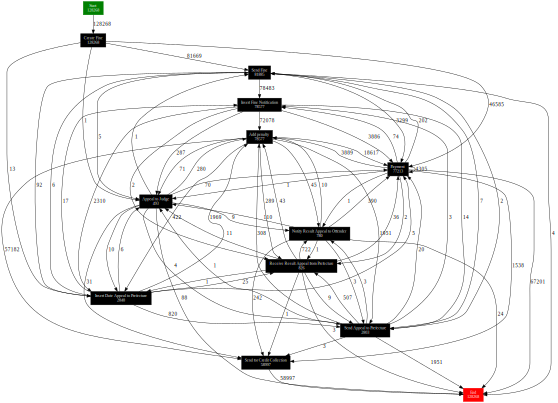

In [41]:
g = graphviz.Digraph('neato', format='png', encoding='utf8',
            filename='2_way_match', node_attr={'color': 'black', 'style': 'filled', 'fontcolor':'white','fontsize':'11'}, 
                     edge_attr={'weight': '1'})
g.attr('node', shape='box')
g.attr(rankdir='TB')
# h.attr(nodesep='0.1')
g.attr(size='7.75,10.25')

# max_node = 5
# max_case_id = sortnewtimetest['Count'].max()

# create all the possible nodes first
# you can modify the `label` 

for index, row in start_act.iterrows():
    g.node(row['Start'],label=row['Start'] + '\n '+ str(start_act[start_act['Start'] == row['Start']]['Count'].sum()), _attributes={'color':'green', 'fontcolor':'white'})
#     , _attributes={'color':'green', 'fontcolor':'white'}
    g.node(row['First Activity'],label=row['First Activity'] + '\n '+ str(start_act[start_act['First Activity'] == row['First Activity']]['Count'].sum()))

for index, row in start_act.iterrows():
    starrt, firstact, count = [str(i) for i in row]
    g.edge(str(row["Start"]), str(row["First Activity"]), label="  " + count)
# , penwidth=str(int(row["Weight"])/max_case_id*max_node)
######################################################

for index, row in pro_det.iterrows():
    g.node(row['event'],label=row['event'] + '\n '+ str(gra_coun[gra_coun['event'] == row['event']]['Count'].sum()))
    g.node(row['event_2'],label=row['event_2'] + '\n '+ str(gra_coun[gra_coun['event'] == row['event_2']]['Count'].sum()))

for index, row in pro_det.iterrows():
    startevent, endevent, count = [str(i) for i in row]
    g.edge(str(row["event"]), str(row["event_2"]), label= "  " + count)
# , penwidth=str(int(row["Count"])/max_case_id*max_node)
######################################################

for index, row in end_act.iterrows():
    g.node(row['Last Activity'],label=row['Last Activity'] + '\n '+ str(gra_coun[gra_coun['event'] == row['Last Activity']]['Count'].sum()))
    g.node(row['End'],label=row['End'] + '\n '+ str(end_act[end_act['End'] == row['End']]['Count'].sum()) , _attributes={'color':'red', 'fontcolor':'white'})
# ,  _attributes={'color':'red', 'fontcolor':'white'}
for index, row in end_act.iterrows():
    lastact, endact, count = [str(i) for i in row]
    g.edge(str(row["Last Activity"]), str(row["End"]), label= "  " + count)
# , penwidth=str(int(row["Weight"])/max_case_id*max_node)
######################################################

# g.view()
g

### Transition Matrix<a class="anchor" id="TransitionMatrix"></a>

The aim of this transition matrix shows how the cases moves from one event to another. The row shows the starting event, while the column shows the preceeding events, while the numbers indicates how many times this was done. For example, <i>Add penalty</i> was followed by <i>Appeal to Judge</i> 71 times. 

The following were noted:
- <b>Appeal to Judge</b>: There are 10 cases where 
- <b>Payment -> Send Fine</b>: Send fine activity was done after Payment was made 202 times. This means that the responsible officers were not notified on time when the payment was made and an avoidable postal expense was made.


In [42]:
def process_details_test(df, case_id, timestamp, activities):
    # Get the dataframe
    df_1 = df.copy()
    df_1 = df_1[[case_id, timestamp, activities]]
    df_1 = df_1.merge(df_1.shift(-1), left_index=True, right_index=True, suffixes=('', '_2'))
    df_1 = df_1[df_1[case_id] == df_1[case_id+'_2']]
    return df_1

In [43]:
process_details_test(df_final, 'case', 'startTime', 'event').pivot_table(index='event', columns='event_2', values='case',aggfunc='count').fillna(0)

event_2,Add penalty,Appeal to Judge,Insert Date Appeal to Prefecture,Insert Fine Notification,Notify Result Appeal to Offender,Payment,Receive Result Appeal from Prefecture,Send Appeal to Prefecture,Send Fine,Send for Credit Collection
event,,,,,,,,,,
Add penalty,0.0,71.0,422.0,0.0,45.0,18617.0,289.0,1951.0,0.0,57182.0
Appeal to Judge,280.0,0.0,10.0,0.0,9.0,70.0,0.0,4.0,1.0,31.0
Create Fine,0.0,1.0,13.0,0.0,0.0,46585.0,0.0,0.0,81669.0,0.0
Insert Date Appeal to Prefecture,1969.0,6.0,0.0,17.0,0.0,5.0,25.0,820.0,6.0,0.0
Insert Fine Notification,72078.0,287.0,2310.0,0.0,0.0,3886.0,2.0,14.0,0.0,0.0
Notify Result Appeal to Offender,10.0,110.0,0.0,0.0,0.0,390.0,1.0,3.0,0.0,242.0
Payment,3889.0,1.0,0.0,74.0,1.0,4305.0,2.0,0.0,202.0,1538.0
Receive Result Appeal from Prefecture,43.0,11.0,1.0,0.0,722.0,36.0,0.0,9.0,0.0,1.0
Send Appeal to Prefecture,308.0,1.0,0.0,3.0,3.0,20.0,507.0,0.0,7.0,3.0


In [44]:
proc_det = process_details_test(df_final, 'case', 'startTime', 'event')
proc_det

,case,startTime,event,case_2,startTime_2,event_2
0,A100,2006-08-01 23:00:00,Create Fine,A100,2006-12-12 00:00:00,Send Fine
1,A100,2006-12-12 00:00:00,Send Fine,A100,2007-01-15 00:00:00,Insert Fine Notification
2,A100,2007-01-15 00:00:00,Insert Fine Notification,A100,2007-03-16 00:00:00,Add penalty
3,A100,2007-03-16 00:00:00,Add penalty,A100,2009-03-29 23:00:00,Send for Credit Collection
5,A10000,2007-03-09 00:00:00,Create Fine,A10000,2007-07-16 23:00:00,Send Fine
...,...,...,...,...,...,...
511260,V9998,2002-12-30 00:00:00,Add penalty,V9998,2004-01-10 00:00:00,Send for Credit Collection
511262,V9999,2002-09-06 23:00:00,Create Fine,V9999,2002-10-24 23:00:00,Send Fine
511263,V9999,2002-10-24 23:00:00,Send Fine,V9999,2002-11-04 00:00:00,Insert Fine Notification
511264,V9999,2002-11-04 00:00:00,Insert Fine Notification,V9999,2003-01-03 00:00:00,Add penalty


In [45]:
# proc_det.to_csv('Process_details.csv', index=False)

### Process Deviation <a class="anchor" id="ConformanceChecking"></a>


#### 1. Other dismissal variables
* <b>G</b>: This dismissal variable appears in <i>93</i> cases. It is used by only one user (<i>User 0</i>). It appears in 5 events with the highest occurence when there is an appeal to a Judge (88.57%). It was used for fines created between April 21 2003 to June 19 2009 and occurs in 18 variants.
* <b>4</b>: This dismissal variable appears in only 2 cases and used in one article (142). Used by 2 users (User 53 and User 11) for fines created in August and December 2004 and occurs in 2 variants (Variant 3 and Variant 4).
* <b>@</b>: This dismissal variable appears in 9 cases and two variants (Variant 1 and variant 8), used by 7 users (User 537, 550, 35, 8, 29, 31, and 536). All fines were created between January 3 and June 3 2000. Article 7, 157 & 158.
* <b>D</b>: Used once for the case created on 2 June 2011 by User 848. Appears in one case. Aritcle 158.
* <b>Z</b>: Used once for the case created on June 16 2000 by user 811.

#### 2. Create fine event
When a fine is created i.e., <i>Create Fine</i> activity, the dismissal value is <b>NIL</b>. While the <b>NIL</b> variable is used for almost all cases in this activity, other variables are used as shown below.

#### 3. Successful dismissal
As highlighted above, there are some cases where the successful dismissal variable is used (<i>G</i> and <i>#</i>) but those cases do not end with Send appeal to judge or prefecture.

#### 4. Receive Result Appeal from prefecture
This activity is usually done when the appeal to the prefecture was not successful and should have a <i>NIL</i> dismissal variable. Below, there are 24 cases where a <i>#</i> variable was used instead.

In [46]:
df_final.groupby(['event','dismissal']).agg({'case':['nunique']})

case
                                                nunique
event                                 dismissal        
Add penalty                           #               6
                                      4               2
                                      @               9
                                      D               1
                                      G               2
                                      NIL         78556
                                      Z               1
Appeal to Judge                       G              93
                                      NIL           400
Create Fine                           4               2
                                      @               9
                                      D               1
                                      NIL        128255
                                      Z               1
Insert Date Appeal to Prefecture      G               3
                                      NIL          2845
Insert Fine Notification              4               2
                                      @               9
                                      D               1
                                      NIL         78564
                                      Z               1
Notify Result Appeal to Offender      #              22
                                      G               5
                                      NIL           753
Payment                               #               1
                                      4               2
                                      @               1
                                      D               1
                                      G               2
                                      NIL         69321
Receive Result Appeal from Prefecture #              24
                                      NIL           802
Send Appeal to Prefecture             #            1980
                                      NIL           823
Send Fine                             #               4
                                      4               2
                                      @               9
                                      D               1
                                      NIL         81868
                                      Z               1
Send for Credit Collection            @               9
                                      NIL         58987
                                      Z               1

## Timing Analysis<a class="anchor" id="TimingAnalysis"></a>

### Case duration<a class="anchor" id="CaseDuration"></a>

We expect that a case will be completed (i.e., sent for credit collection or paid) within 6 months of creation. Here, we looked at the various cases and their duration. We found out that 75,259 i.e., 59% of cases were completed after 180 days. 

#### Compliance checking
6 months rule is not followed. 

In [47]:
def case_duration(df, case_id, dates):
    case_dur = df.copy()
    case_dur['Count'] = case_dur.groupby(case_id).cumcount()+1
    case_dur = case_dur.pivot(index=case_id, columns='Count', values=dates)
    case_dur_col = case_dur.columns
    case_dur['Max'] = case_dur.apply(max, axis=1)
    case_dur['Case_Duration_days'] = (case_dur['Max'] - case_dur[1]).dt.days
    case_dur = case_dur.drop(case_dur_col, axis=1)
    case_dur.reset_index(inplace=True)    
    return case_dur

In [48]:
case_duration(df_final,'case','startTime').drop('Max', axis=1)

Count,case,Case_Duration_days
0,A100,971
1,A10000,549
2,A10001,188
3,A10004,740
4,A10005,1
...,...,...
128263,V9995,490
128264,V9996,60
128265,V9997,490
128266,V9998,490


### Event duration<a class="anchor" id="EventDuration"></a>

Here we wanted to see the average days spent on each event and which event on average takes most times. Here are the findings:
1. Send for credit collection is the activity that takes most of the time. It takes an average of 525 days before this activity is performed. Further analysis showed that only 84 fines were sent to credit collection within 180 days.

2. The Add penalty activity is being adhered to as the maximum days before a penalty is added is 60 days from the fine's creation

In [49]:
df_final.groupby(['event'])['Duration'].mean().round(0)

event
Add penalty                               57.0
Appeal to Judge                           35.0
Create Fine                                0.0
Insert Date Appeal to Prefecture          33.0
Insert Fine Notification                  17.0
Notify Result Appeal to Offender          34.0
Payment                                   55.0
Receive Result Appeal from Prefecture     53.0
Send Appeal to Prefecture                 26.0
Send Fine                                 85.0
Send for Credit Collection               525.0
Name: Duration, dtype: float64

In [50]:
df_final.groupby(['event'])['Duration'].max().round(0)

event
Add penalty                                60.0
Appeal to Judge                          1921.0
Create Fine                                 0.0
Insert Date Appeal to Prefecture          558.0
Insert Fine Notification                  432.0
Notify Result Appeal to Offender          226.0
Payment                                  1681.0
Receive Result Appeal from Prefecture     238.0
Send Appeal to Prefecture                 733.0
Send Fine                                 732.0
Send for Credit Collection               3330.0
Name: Duration, dtype: float64

In [51]:
distinct_df = distinct_df.merge(case_duration(df_final,'case','startTime').drop('Max', axis=1))
distinct_df

Count,Variants,Trace,No of occurance,case,Case_Duration_days
0,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A100,971
1,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10004,740
2,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10008,740
3,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A1001,971
4,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10010,740
...,...,...,...,...,...
128263,189,"Create Fine,Send Fine,Insert Fine Notification...",1,A823,493
128264,190,"Create Fine,Send Fine,Insert Fine Notification...",1,S87107,771
128265,191,"Create Fine,Send Fine,Insert Fine Notification...",1,N67142,845
128266,192,"Create Fine,Send Fine,Insert Fine Notification...",1,V18908,739


In [52]:
distinct_df = distinct_df.merge(df_final.groupby('case').head(1), on='case')
distinct_df

,Variants,Trace,No of occurance,case,Case_Duration_days,event,startTime,completeTime,amount,notificationType,...,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola,Duration,Event_ID
0,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A100,971,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,35.0,NaN,...,NaN,157,0,561,NIL,A,0.0,NaN,0.0,1
1,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10004,740,Create Fine,2007-03-20 00:00:00,2007-03-20 00:00:00,36.0,NaN,...,NaN,157,0,537,NIL,A,0.0,NaN,0.0,1
2,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10008,740,Create Fine,2007-03-20 00:00:00,2007-03-20 00:00:00,36.0,NaN,...,NaN,157,0,537,NIL,A,0.0,NaN,0.0,1
3,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A1001,971,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,21.0,NaN,...,NaN,7,0,550,NIL,A,0.0,NaN,0.0,1
4,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10010,740,Create Fine,2007-03-20 00:00:00,2007-03-20 00:00:00,36.0,NaN,...,NaN,157,0,537,NIL,A,0.0,NaN,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,189,"Create Fine,Send Fine,Insert Fine Notification...",1,A823,493,Create Fine,2006-08-11 23:00:00,2006-08-11 23:00:00,35.0,NaN,...,NaN,157,0,541,NIL,A,0.0,NaN,0.0,1
128264,190,"Create Fine,Send Fine,Insert Fine Notification...",1,S87107,771,Create Fine,2003-08-12 23:00:00,2003-08-12 23:00:00,33.6,NaN,...,NaN,7,0,824,NIL,A,0.0,NaN,0.0,1
128265,191,"Create Fine,Send Fine,Insert Fine Notification...",1,N67142,845,Create Fine,2004-11-05 00:00:00,2004-11-05 00:00:00,33.6,NaN,...,NaN,157,0,537,NIL,A,0.0,NaN,0.0,1
128266,192,"Create Fine,Send Fine,Insert Fine Notification...",1,V18908,739,Create Fine,2010-03-17 00:00:00,2010-03-17 00:00:00,155.0,NaN,...,NaN,142,5,29,NIL,A,0.0,NaN,0.0,1


In [53]:
first_last = activity_list(df_final,'case','event').reset_index()
first_last = first_last[['case','Last Activity','First Activity']]
first_last

Count,case,Last Activity,First Activity
0,A100,Send for Credit Collection,Create Fine
1,A10000,Payment,Create Fine
2,A10001,Send Appeal to Prefecture,Create Fine
3,A10004,Send for Credit Collection,Create Fine
4,A10005,Payment,Create Fine
...,...,...,...
128263,V9995,Send for Credit Collection,Create Fine
128264,V9996,Payment,Create Fine
128265,V9997,Send for Credit Collection,Create Fine
128266,V9998,Send for Credit Collection,Create Fine


In [54]:
distinct_df = distinct_df.merge(first_last, on='case')
distinct_df

,Variants,Trace,No of occurance,case,Case_Duration_days,event,startTime,completeTime,amount,notificationType,...,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola,Duration,Event_ID,Last Activity,First Activity
0,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A100,971,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,35.0,NaN,...,0,561,NIL,A,0.0,NaN,0.0,1,Send for Credit Collection,Create Fine
1,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10004,740,Create Fine,2007-03-20 00:00:00,2007-03-20 00:00:00,36.0,NaN,...,0,537,NIL,A,0.0,NaN,0.0,1,Send for Credit Collection,Create Fine
2,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10008,740,Create Fine,2007-03-20 00:00:00,2007-03-20 00:00:00,36.0,NaN,...,0,537,NIL,A,0.0,NaN,0.0,1,Send for Credit Collection,Create Fine
3,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A1001,971,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,21.0,NaN,...,0,550,NIL,A,0.0,NaN,0.0,1,Send for Credit Collection,Create Fine
4,1,"Create Fine,Send Fine,Insert Fine Notification...",56482,A10010,740,Create Fine,2007-03-20 00:00:00,2007-03-20 00:00:00,36.0,NaN,...,0,537,NIL,A,0.0,NaN,0.0,1,Send for Credit Collection,Create Fine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,189,"Create Fine,Send Fine,Insert Fine Notification...",1,A823,493,Create Fine,2006-08-11 23:00:00,2006-08-11 23:00:00,35.0,NaN,...,0,541,NIL,A,0.0,NaN,0.0,1,Payment,Create Fine
128264,190,"Create Fine,Send Fine,Insert Fine Notification...",1,S87107,771,Create Fine,2003-08-12 23:00:00,2003-08-12 23:00:00,33.6,NaN,...,0,824,NIL,A,0.0,NaN,0.0,1,Payment,Create Fine
128265,191,"Create Fine,Send Fine,Insert Fine Notification...",1,N67142,845,Create Fine,2004-11-05 00:00:00,2004-11-05 00:00:00,33.6,NaN,...,0,537,NIL,A,0.0,NaN,0.0,1,Send for Credit Collection,Create Fine
128266,192,"Create Fine,Send Fine,Insert Fine Notification...",1,V18908,739,Create Fine,2010-03-17 00:00:00,2010-03-17 00:00:00,155.0,NaN,...,5,29,NIL,A,0.0,NaN,0.0,1,Send for Credit Collection,Create Fine


In [55]:
distinct_df_extract = distinct_df[['case', 'Variants', 'No of occurance', 'Case_Duration_days', 'startTime', 'article', 'points',
       'org:resource', 'vehicleClass', 'Last Activity', 'First Activity']]
distinct_df_extract

,case,Variants,No of occurance,Case_Duration_days,startTime,article,points,org:resource,vehicleClass,Last Activity,First Activity
0,A100,1,56482,971,2006-08-01 23:00:00,157,0,561,A,Send for Credit Collection,Create Fine
1,A10004,1,56482,740,2007-03-20 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine
2,A10008,1,56482,740,2007-03-20 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine
3,A1001,1,56482,971,2006-08-01 23:00:00,7,0,550,A,Send for Credit Collection,Create Fine
4,A10010,1,56482,740,2007-03-20 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine
...,...,...,...,...,...,...,...,...,...,...,...
128263,A823,189,1,493,2006-08-11 23:00:00,157,0,541,A,Payment,Create Fine
128264,S87107,190,1,771,2003-08-12 23:00:00,7,0,824,A,Payment,Create Fine
128265,N67142,191,1,845,2004-11-05 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine
128266,V18908,192,1,739,2010-03-17 00:00:00,142,5,29,A,Send for Credit Collection,Create Fine


In [56]:
distinct_df_extract_2 = df_final.groupby('case').tail(1)
distinct_df_extract_2 = distinct_df_extract_2[['case','completeTime','amount','expense','paymentAmount','totalPaymentAmount']]
distinct_df_extract_2

,case,completeTime,amount,expense,paymentAmount,totalPaymentAmount
4,A100,2009-03-29 23:00:00,71.5,11.00,NaN,0.00
9,A10000,2008-09-08 23:00:00,74.0,13.00,87.00,87.00
15,A10001,2007-09-23 23:00:00,74.0,13.00,NaN,0.00
20,A10004,2009-03-29 23:00:00,74.0,13.00,NaN,0.00
22,A10005,2007-03-21 00:00:00,36.0,NaN,36.00,36.00
...,...,...,...,...,...,...
511248,V9995,2004-01-10 00:00:00,262.0,15.16,NaN,0.00
511251,V9996,2002-11-06 00:00:00,131.0,10.00,146.16,146.16
511256,V9997,2004-01-10 00:00:00,262.0,15.16,NaN,0.00
511261,V9998,2004-01-10 00:00:00,262.0,10.00,NaN,0.00


In [57]:
distinct_df = distinct_df_extract.merge(distinct_df_extract_2, on='case')
distinct_df

,case,Variants,No of occurance,Case_Duration_days,startTime,article,points,org:resource,vehicleClass,Last Activity,First Activity,completeTime,amount,expense,paymentAmount,totalPaymentAmount
0,A100,1,56482,971,2006-08-01 23:00:00,157,0,561,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,71.50,11.00,NaN,0.00
1,A10004,1,56482,740,2007-03-20 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,74.00,13.00,NaN,0.00
2,A10008,1,56482,740,2007-03-20 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,74.00,13.00,NaN,0.00
3,A1001,1,56482,971,2006-08-01 23:00:00,7,0,550,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,42.50,11.00,NaN,0.00
4,A10010,1,56482,740,2007-03-20 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,74.00,13.00,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,A823,189,1,493,2006-08-11 23:00:00,157,0,541,A,Payment,Create Fine,2007-12-18 00:00:00,71.50,11.00,82.50,82.50
128264,S87107,190,1,771,2003-08-12 23:00:00,7,0,824,A,Payment,Create Fine,2005-09-21 23:00:00,68.77,10.00,43.60,43.60
128265,N67142,191,1,845,2004-11-05 00:00:00,157,0,537,A,Send for Credit Collection,Create Fine,2007-02-28 00:00:00,68.77,11.00,6.70,29.77
128266,V18908,192,1,739,2010-03-17 00:00:00,142,5,29,A,Send for Credit Collection,Create Fine,2012-03-25 23:00:00,312.00,13.50,30.00,300.00


In [58]:
# distinct_df.to_csv('Distinct_log.csv', index=False)

In [59]:
event_duration = df_final.pivot_table(index='case', columns='event', values='startTime', aggfunc='first').reset_index()
event_duration

event,case,Add penalty,Appeal to Judge,Create Fine,Insert Date Appeal to Prefecture,Insert Fine Notification,Notify Result Appeal to Offender,Payment,Receive Result Appeal from Prefecture,Send Appeal to Prefecture,Send Fine,Send for Credit Collection
0,A100,2007-03-16 00:00:00,NaT,2006-08-01 23:00:00,NaT,2007-01-15 00:00:00,NaT,NaT,NaT,NaT,2006-12-12 00:00:00,2009-03-29 23:00:00
1,A10000,2007-09-30 23:00:00,NaT,2007-03-09 00:00:00,NaT,2007-08-01 23:00:00,NaT,2008-09-08 23:00:00,NaT,NaT,2007-07-16 23:00:00,NaT
2,A10001,2007-09-22 23:00:00,NaT,2007-03-19 00:00:00,2007-08-01 23:00:00,2007-07-24 23:00:00,NaT,NaT,NaT,2007-09-23 23:00:00,2007-07-16 23:00:00,NaT
3,A10004,2007-09-21 23:00:00,NaT,2007-03-20 00:00:00,NaT,2007-07-23 23:00:00,NaT,NaT,NaT,NaT,2007-07-16 23:00:00,2009-03-29 23:00:00
4,A10005,NaT,NaT,2007-03-20 00:00:00,NaT,NaT,NaT,2007-03-21 00:00:00,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
128263,V9995,2003-01-04 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-05 00:00:00,NaT,NaT,NaT,NaT,2002-10-24 23:00:00,2004-01-10 00:00:00
128264,V9996,NaT,NaT,2002-09-06 23:00:00,NaT,NaT,NaT,2002-11-06 00:00:00,NaT,NaT,2002-10-24 23:00:00,NaT
128265,V9997,2003-01-03 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-04 00:00:00,NaT,NaT,NaT,NaT,2002-10-24 23:00:00,2004-01-10 00:00:00
128266,V9998,2002-12-30 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-10-31 00:00:00,NaT,NaT,NaT,NaT,2002-10-24 23:00:00,2004-01-10 00:00:00


In [60]:
event_duration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128268 entries, 0 to 128267
Data columns (total 12 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   case                                   128268 non-null  object        
 1   Add penalty                            78577 non-null   datetime64[ns]
 2   Appeal to Judge                        493 non-null     datetime64[ns]
 3   Create Fine                            128268 non-null  datetime64[ns]
 4   Insert Date Appeal to Prefecture       2848 non-null    datetime64[ns]
 5   Insert Fine Notification               78577 non-null   datetime64[ns]
 6   Notify Result Appeal to Offender       780 non-null     datetime64[ns]
 7   Payment                                69328 non-null   datetime64[ns]
 8   Receive Result Appeal from Prefecture  826 non-null     datetime64[ns]
 9   Send Appeal to Prefecture              2803 non-

In [61]:
# event_duration.to_csv('Event_duration.csv', index=False)

In [62]:
event_duration_2 = event_duration.copy()
event_duration_2['DelaySend'] = (event_duration_2['Send Fine']-event_duration_2['Create Fine']).dt.days
event_duration_2['DelayJudge'] = (event_duration_2['Appeal to Judge']-event_duration_2['Insert Fine Notification']).dt.days
event_duration_2['DelayPrefecture'] = (event_duration_2['Send Appeal to Prefecture']-event_duration_2['Insert Fine Notification']).dt.days
event_duration_2['FinetoPenalty'] = (event_duration_2['Add penalty']-event_duration_2['Insert Fine Notification']).dt.days
event_duration_2['PenaltytoCredit'] = (event_duration_2['Send for Credit Collection']-event_duration_2['Add penalty']).dt.days
event_duration_2

event,case,Add penalty,Appeal to Judge,Create Fine,Insert Date Appeal to Prefecture,Insert Fine Notification,Notify Result Appeal to Offender,Payment,Receive Result Appeal from Prefecture,Send Appeal to Prefecture,Send Fine,Send for Credit Collection,DelaySend,DelayJudge,DelayPrefecture,FinetoPenalty,PenaltytoCredit
0,A100,2007-03-16 00:00:00,NaT,2006-08-01 23:00:00,NaT,2007-01-15 00:00:00,NaT,NaT,NaT,NaT,2006-12-12 00:00:00,2009-03-29 23:00:00,132.0,NaN,NaN,60.0,744.0
1,A10000,2007-09-30 23:00:00,NaT,2007-03-09 00:00:00,NaT,2007-08-01 23:00:00,NaT,2008-09-08 23:00:00,NaT,NaT,2007-07-16 23:00:00,NaT,129.0,NaN,NaN,60.0,NaN
2,A10001,2007-09-22 23:00:00,NaT,2007-03-19 00:00:00,2007-08-01 23:00:00,2007-07-24 23:00:00,NaT,NaT,NaT,2007-09-23 23:00:00,2007-07-16 23:00:00,NaT,119.0,NaN,61.0,60.0,NaN
3,A10004,2007-09-21 23:00:00,NaT,2007-03-20 00:00:00,NaT,2007-07-23 23:00:00,NaT,NaT,NaT,NaT,2007-07-16 23:00:00,2009-03-29 23:00:00,118.0,NaN,NaN,60.0,555.0
4,A10005,NaT,NaT,2007-03-20 00:00:00,NaT,NaT,NaT,2007-03-21 00:00:00,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,V9995,2003-01-04 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-05 00:00:00,NaT,NaT,NaT,NaT,2002-10-24 23:00:00,2004-01-10 00:00:00,48.0,NaN,NaN,60.0,371.0
128264,V9996,NaT,NaT,2002-09-06 23:00:00,NaT,NaT,NaT,2002-11-06 00:00:00,NaT,NaT,2002-10-24 23:00:00,NaT,48.0,NaN,NaN,NaN,NaN
128265,V9997,2003-01-03 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-04 00:00:00,NaT,NaT,NaT,NaT,2002-10-24 23:00:00,2004-01-10 00:00:00,48.0,NaN,NaN,60.0,372.0
128266,V9998,2002-12-30 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-10-31 00:00:00,NaT,NaT,NaT,NaT,2002-10-24 23:00:00,2004-01-10 00:00:00,48.0,NaN,NaN,60.0,376.0


In [63]:
event_duration_2 = event_duration_2.merge(distinct_df, on='case')
event_duration_2

,case,Add penalty,Appeal to Judge,Create Fine,Insert Date Appeal to Prefecture,Insert Fine Notification,Notify Result Appeal to Offender,Payment,Receive Result Appeal from Prefecture,Send Appeal to Prefecture,...,points,org:resource,vehicleClass,Last Activity,First Activity,completeTime,amount,expense,paymentAmount,totalPaymentAmount
0,A100,2007-03-16 00:00:00,NaT,2006-08-01 23:00:00,NaT,2007-01-15 00:00:00,NaT,NaT,NaT,NaT,...,0,561,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,71.5,11.00,NaN,0.00
1,A10000,2007-09-30 23:00:00,NaT,2007-03-09 00:00:00,NaT,2007-08-01 23:00:00,NaT,2008-09-08 23:00:00,NaT,NaT,...,0,561,A,Payment,Create Fine,2008-09-08 23:00:00,74.0,13.00,87.00,87.00
2,A10001,2007-09-22 23:00:00,NaT,2007-03-19 00:00:00,2007-08-01 23:00:00,2007-07-24 23:00:00,NaT,NaT,NaT,2007-09-23 23:00:00,...,0,537,A,Send Appeal to Prefecture,Create Fine,2007-09-23 23:00:00,74.0,13.00,NaN,0.00
3,A10004,2007-09-21 23:00:00,NaT,2007-03-20 00:00:00,NaT,2007-07-23 23:00:00,NaT,NaT,NaT,NaT,...,0,537,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,74.0,13.00,NaN,0.00
4,A10005,NaT,NaT,2007-03-20 00:00:00,NaT,NaT,NaT,2007-03-21 00:00:00,NaT,NaT,...,0,537,A,Payment,Create Fine,2007-03-21 00:00:00,36.0,NaN,36.00,36.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,V9995,2003-01-04 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-05 00:00:00,NaT,NaT,NaT,NaT,...,0,25,A,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00
128264,V9996,NaT,NaT,2002-09-06 23:00:00,NaT,NaT,NaT,2002-11-06 00:00:00,NaT,NaT,...,0,25,A,Payment,Create Fine,2002-11-06 00:00:00,131.0,10.00,146.16,146.16
128265,V9997,2003-01-03 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-04 00:00:00,NaT,NaT,NaT,NaT,...,0,25,M,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00
128266,V9998,2002-12-30 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-10-31 00:00:00,NaT,NaT,NaT,NaT,...,0,25,A,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,10.00,NaN,0.00


In [64]:
event_duration_2['totFineAmt'] = event_duration_2['amount']+event_duration_2['expense']
event_duration_2

,case,Add penalty,Appeal to Judge,Create Fine,Insert Date Appeal to Prefecture,Insert Fine Notification,Notify Result Appeal to Offender,Payment,Receive Result Appeal from Prefecture,Send Appeal to Prefecture,...,org:resource,vehicleClass,Last Activity,First Activity,completeTime,amount,expense,paymentAmount,totalPaymentAmount,totFineAmt
0,A100,2007-03-16 00:00:00,NaT,2006-08-01 23:00:00,NaT,2007-01-15 00:00:00,NaT,NaT,NaT,NaT,...,561,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,71.5,11.00,NaN,0.00,82.50
1,A10000,2007-09-30 23:00:00,NaT,2007-03-09 00:00:00,NaT,2007-08-01 23:00:00,NaT,2008-09-08 23:00:00,NaT,NaT,...,561,A,Payment,Create Fine,2008-09-08 23:00:00,74.0,13.00,87.00,87.00,87.00
2,A10001,2007-09-22 23:00:00,NaT,2007-03-19 00:00:00,2007-08-01 23:00:00,2007-07-24 23:00:00,NaT,NaT,NaT,2007-09-23 23:00:00,...,537,A,Send Appeal to Prefecture,Create Fine,2007-09-23 23:00:00,74.0,13.00,NaN,0.00,87.00
3,A10004,2007-09-21 23:00:00,NaT,2007-03-20 00:00:00,NaT,2007-07-23 23:00:00,NaT,NaT,NaT,NaT,...,537,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,74.0,13.00,NaN,0.00,87.00
4,A10005,NaT,NaT,2007-03-20 00:00:00,NaT,NaT,NaT,2007-03-21 00:00:00,NaT,NaT,...,537,A,Payment,Create Fine,2007-03-21 00:00:00,36.0,NaN,36.00,36.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,V9995,2003-01-04 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-05 00:00:00,NaT,NaT,NaT,NaT,...,25,A,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00,277.16
128264,V9996,NaT,NaT,2002-09-06 23:00:00,NaT,NaT,NaT,2002-11-06 00:00:00,NaT,NaT,...,25,A,Payment,Create Fine,2002-11-06 00:00:00,131.0,10.00,146.16,146.16,141.00
128265,V9997,2003-01-03 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-04 00:00:00,NaT,NaT,NaT,NaT,...,25,M,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00,277.16
128266,V9998,2002-12-30 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-10-31 00:00:00,NaT,NaT,NaT,NaT,...,25,A,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,10.00,NaN,0.00,272.00


In [65]:
conditions = [
    event_duration_2['totalPaymentAmount'] == 0,
    event_duration_2['totalPaymentAmount'] == event_duration_2['totFineAmt'],
    event_duration_2['totalPaymentAmount'] > event_duration_2['totFineAmt']
]

values = ['Not Paid', 'Paid', 'Over Paid']

# Use np.select to apply the conditions and assign corresponding values
event_duration_2['PaymentStatus'] = np.select(conditions, values, default='Under Paid')
event_duration_2

,case,Add penalty,Appeal to Judge,Create Fine,Insert Date Appeal to Prefecture,Insert Fine Notification,Notify Result Appeal to Offender,Payment,Receive Result Appeal from Prefecture,Send Appeal to Prefecture,...,vehicleClass,Last Activity,First Activity,completeTime,amount,expense,paymentAmount,totalPaymentAmount,totFineAmt,PaymentStatus
0,A100,2007-03-16 00:00:00,NaT,2006-08-01 23:00:00,NaT,2007-01-15 00:00:00,NaT,NaT,NaT,NaT,...,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,71.5,11.00,NaN,0.00,82.50,Not Paid
1,A10000,2007-09-30 23:00:00,NaT,2007-03-09 00:00:00,NaT,2007-08-01 23:00:00,NaT,2008-09-08 23:00:00,NaT,NaT,...,A,Payment,Create Fine,2008-09-08 23:00:00,74.0,13.00,87.00,87.00,87.00,Paid
2,A10001,2007-09-22 23:00:00,NaT,2007-03-19 00:00:00,2007-08-01 23:00:00,2007-07-24 23:00:00,NaT,NaT,NaT,2007-09-23 23:00:00,...,A,Send Appeal to Prefecture,Create Fine,2007-09-23 23:00:00,74.0,13.00,NaN,0.00,87.00,Not Paid
3,A10004,2007-09-21 23:00:00,NaT,2007-03-20 00:00:00,NaT,2007-07-23 23:00:00,NaT,NaT,NaT,NaT,...,A,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,74.0,13.00,NaN,0.00,87.00,Not Paid
4,A10005,NaT,NaT,2007-03-20 00:00:00,NaT,NaT,NaT,2007-03-21 00:00:00,NaT,NaT,...,A,Payment,Create Fine,2007-03-21 00:00:00,36.0,NaN,36.00,36.00,NaN,Under Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,V9995,2003-01-04 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-05 00:00:00,NaT,NaT,NaT,NaT,...,A,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00,277.16,Not Paid
128264,V9996,NaT,NaT,2002-09-06 23:00:00,NaT,NaT,NaT,2002-11-06 00:00:00,NaT,NaT,...,A,Payment,Create Fine,2002-11-06 00:00:00,131.0,10.00,146.16,146.16,141.00,Over Paid
128265,V9997,2003-01-03 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-04 00:00:00,NaT,NaT,NaT,NaT,...,M,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00,277.16,Not Paid
128266,V9998,2002-12-30 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-10-31 00:00:00,NaT,NaT,NaT,NaT,...,A,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,10.00,NaN,0.00,272.00,Not Paid


In [66]:
event_duration_2.groupby(['Last Activity','PaymentStatus']).agg({'case':['nunique']})

case
                                                    nunique
Last Activity                         PaymentStatus        
Appeal to Judge                       Not Paid           88
Notify Result Appeal to Offender      Not Paid           24
Payment                               Over Paid        1378
                                      Paid            12514
                                      Under Paid      53309
Receive Result Appeal from Prefecture Not Paid            3
Send Appeal to Prefecture             Not Paid         1950
                                      Under Paid          1
Send Fine                             Not Paid            4
Send for Credit Collection            Not Paid        56871
                                      Over Paid           1
                                      Paid                1
                                      Under Paid       2124

### Conformance Checking <a class="anchor" id="ConformanceChecking2"></a>

After the analysis above, it is time to carry out some conformance check relating to timing.

1. There are 37,266 cases where the fine was sent after 90 days. Out of these fines which were delayed, 70% of them were sent to the credit collection agency. This might be because the offenders are already aware that these fines were sent out late and there would be no repercussion for not paying. The traffic prefects should be trained/reminded of this rule to avoid offenders getting away with fines. This also incurs cost to the management by paying for postal expenses which would not be recovered

2. There are 53,309 fines which have not been fully paid, but have not been sent to the credit collection agency.

3. The 60 days time limit for appeals are not been adhered to by the offenders. Of the fines appealed to the judge, 36% of them were done after 60 days, while for those appealed to the prefect, 81% of them were done after 60 days. We are not sure if this time indicated when the actual appeal was made or when the prefect recorded this in the system. Either way, this shows a deviation from the expected process.

In [67]:
data = {
    'KPIs':['Send fine > 90 days', 'Appeal to Judge > 60 days','Appeal to Prefecture > 60 days',
            'Delayed send fine but sent to credit agency','Case duration > 180 days',
            'Under paid but not sent to credit agency'],
    'Count': [(event_duration_2['DelaySend'] > 90).sum(), (event_duration_2['DelayJudge'] > 60).sum(),
              (event_duration_2['DelayPrefecture'] > 60).sum(),
             ((event_duration_2['DelaySend'] > 90) & (event_duration_2['Last Activity'] == 'Send for Credit Collection')).sum(),
             (event_duration_2['Case_Duration_days'] > 180).sum(),
             ((event_duration_2['PaymentStatus'] == 'Under Paid') & (event_duration_2['Last Activity'] == 'Payment')).sum()]
}

pd.DataFrame(data)

,KPIs,Count
0,Send fine > 90 days,37266
1,Appeal to Judge > 60 days,178
2,Appeal to Prefecture > 60 days,2274
3,Delayed send fine but sent to credit agency,26037
4,Case duration > 180 days,75259
5,Under paid but not sent to credit agency,53309


In [68]:
df_final['event'].value_counts()

Create Fine                              128268
Send Fine                                 81885
Insert Fine Notification                  78577
Add penalty                               78577
Payment                                   77213
Send for Credit Collection                58997
Insert Date Appeal to Prefecture           2848
Send Appeal to Prefecture                  2803
Receive Result Appeal from Prefecture       826
Notify Result Appeal to Offender            780
Appeal to Judge                             493
Name: event, dtype: int64

In [69]:
conditions_2 = [
    event_duration_2['Case_Duration_days'] > 180,
    event_duration_2['Case_Duration_days'] > 90,
]

values_2 = ['Above 180 days', '91-180']

# Use np.select to apply the conditions and assign corresponding values
event_duration_2['Nested_Duration'] = np.select(conditions_2, values_2, default='0-90')
event_duration_2

,case,Add penalty,Appeal to Judge,Create Fine,Insert Date Appeal to Prefecture,Insert Fine Notification,Notify Result Appeal to Offender,Payment,Receive Result Appeal from Prefecture,Send Appeal to Prefecture,...,Last Activity,First Activity,completeTime,amount,expense,paymentAmount,totalPaymentAmount,totFineAmt,PaymentStatus,Nested_Duration
0,A100,2007-03-16 00:00:00,NaT,2006-08-01 23:00:00,NaT,2007-01-15 00:00:00,NaT,NaT,NaT,NaT,...,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,71.5,11.00,NaN,0.00,82.50,Not Paid,Above 180 days
1,A10000,2007-09-30 23:00:00,NaT,2007-03-09 00:00:00,NaT,2007-08-01 23:00:00,NaT,2008-09-08 23:00:00,NaT,NaT,...,Payment,Create Fine,2008-09-08 23:00:00,74.0,13.00,87.00,87.00,87.00,Paid,Above 180 days
2,A10001,2007-09-22 23:00:00,NaT,2007-03-19 00:00:00,2007-08-01 23:00:00,2007-07-24 23:00:00,NaT,NaT,NaT,2007-09-23 23:00:00,...,Send Appeal to Prefecture,Create Fine,2007-09-23 23:00:00,74.0,13.00,NaN,0.00,87.00,Not Paid,Above 180 days
3,A10004,2007-09-21 23:00:00,NaT,2007-03-20 00:00:00,NaT,2007-07-23 23:00:00,NaT,NaT,NaT,NaT,...,Send for Credit Collection,Create Fine,2009-03-29 23:00:00,74.0,13.00,NaN,0.00,87.00,Not Paid,Above 180 days
4,A10005,NaT,NaT,2007-03-20 00:00:00,NaT,NaT,NaT,2007-03-21 00:00:00,NaT,NaT,...,Payment,Create Fine,2007-03-21 00:00:00,36.0,NaN,36.00,36.00,NaN,Under Paid,0-90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128263,V9995,2003-01-04 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-05 00:00:00,NaT,NaT,NaT,NaT,...,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00,277.16,Not Paid,Above 180 days
128264,V9996,NaT,NaT,2002-09-06 23:00:00,NaT,NaT,NaT,2002-11-06 00:00:00,NaT,NaT,...,Payment,Create Fine,2002-11-06 00:00:00,131.0,10.00,146.16,146.16,141.00,Over Paid,0-90
128265,V9997,2003-01-03 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-11-04 00:00:00,NaT,NaT,NaT,NaT,...,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,15.16,NaN,0.00,277.16,Not Paid,Above 180 days
128266,V9998,2002-12-30 00:00:00,NaT,2002-09-06 23:00:00,NaT,2002-10-31 00:00:00,NaT,NaT,NaT,NaT,...,Send for Credit Collection,Create Fine,2004-01-10 00:00:00,262.0,10.00,NaN,0.00,272.00,Not Paid,Above 180 days


In [70]:
# event_duration_2.to_csv('Event_duration_2.csv', index=False)

In [71]:
single_variant = distinct_df.groupby('Variants').head(1)
single_variant = single_variant[['case','Variants']]
single_variant = single_variant.merge(df_final, on='case')
single_variant

,case,Variants,event,startTime,completeTime,amount,notificationType,expense,lastSent,paymentAmount,article,points,org:resource,dismissal,vehicleClass,totalPaymentAmount,matricola,Duration,Event_ID
0,A100,1,Create Fine,2006-08-01 23:00:00,2006-08-01 23:00:00,35.0,NaN,NaN,NaN,NaN,157,0,561,NIL,A,0.00,NaN,0.0,1
1,A100,1,Send Fine,2006-12-12 00:00:00,2006-12-12 00:00:00,35.0,NaN,11.00,NaN,NaN,157,0,561,NIL,A,0.00,NaN,132.0,2
2,A100,1,Insert Fine Notification,2007-01-15 00:00:00,2007-01-15 00:00:00,35.0,P,11.00,P,NaN,157,0,561,NIL,A,0.00,NaN,34.0,3
3,A100,1,Add penalty,2007-03-16 00:00:00,2007-03-16 00:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.00,NaN,60.0,4
4,A100,1,Send for Credit Collection,2009-03-29 23:00:00,2009-03-29 23:00:00,71.5,P,11.00,P,NaN,157,0,561,NIL,A,0.00,NaN,744.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,V8443,193,Send Appeal to Prefecture,2001-12-21 00:00:00,2001-12-21 00:00:00,131.2,NaN,6.71,NaN,NaN,142,0,28,NIL,A,0.00,NaN,27.0,3
1626,V8443,193,Insert Fine Notification,2001-12-24 00:00:00,2001-12-24 00:00:00,131.2,P,6.71,N,NaN,142,0,28,NIL,A,0.00,NaN,3.0,4
1627,V8443,193,Insert Date Appeal to Prefecture,2001-12-27 00:00:00,2001-12-27 00:00:00,131.2,P,6.71,N,NaN,142,0,28,NIL,A,0.00,NaN,3.0,5
1628,V8443,193,Add penalty,2002-02-22 00:00:00,2002-02-22 00:00:00,262.4,P,6.71,N,NaN,142,0,28,NIL,A,0.00,NaN,57.0,6


In [72]:
# single_variant.to_csv('Single_variant.csv',index=False)